# Examples
This notebook contains a few examples on how to query the logs and process the results.

## Import the required libraries
For the examples we use the `google-cloud-logging` library to fetch the logs and `pandas` to process the results. However,
you are free to use any Python code/libraries to work with the fetched data.

In [2]:
import google.auth
import google.cloud.logging as gcl
import pandas as pd
import matplotlib.pyplot as plt

## Create a client

**IMPORTANT:** You must have run `gcloud auth application-default login` to authenticate and `gcloud config set project <project-id>` before starting jupyter notebook.

In [3]:
gcp_credentials, project = google.auth.default()
logs = gcl.Client(credentials=gcp_credentials, project=project)

## Query the logs

`page_size` is set to a high number here to reduce the number of request made to the API. Too many requests can result in a `ResourceExhausted 429` error.

In [17]:
log_filter = (
    """
    severity>=WARNING AND timestamp>="2023-05-11T00:00:00Z"
    """
)
results = logs.list_entries(filter_=log_filter, page_size=1000)

Use plain Python to convert the results (which come in the form of `StructEntry` objects) to a list of key value pairs.

In [18]:
entries = [
    dict(
        severity=result.severity,
        timestamp=result.timestamp,
        resource_type=result.resource.type,
    )
    for result in results
]

## Use Pandas to process the results
First put the results in a `DataFrame`

In [20]:
entries_df = pd.DataFrame(entries)


In [50]:
entries_df

,severity,timestamp,resource_type
0,WARNING,2023-05-11 00:00:57.145344+00:00,http_load_balancer
1,WARNING,2023-05-11 00:01:48.716034+00:00,http_load_balancer
2,WARNING,2023-05-11 00:01:48.890428+00:00,http_load_balancer
3,WARNING,2023-05-11 00:02:26.944184+00:00,http_load_balancer
4,WARNING,2023-05-11 00:03:34.590030+00:00,http_load_balancer
...,...,...,...
5391,ERROR,2023-05-11 10:07:08+00:00,gce_instance
5392,ERROR,2023-05-11 10:07:13+00:00,gce_instance
5393,ERROR,2023-05-11 10:07:22+00:00,gce_instance
5394,ERROR,2023-05-11 10:07:28+00:00,gce_instance


Then use [Pandas functionality](https://pandas.pydata.org/docs/) to extract data. Here we get the number of errors and warnings generated by each resource type.

In [44]:
count_by_resource_type = entries_df \
    .groupby(["resource_type"])['resource_type'] \
    .count() \
    .rename("count") \
    .to_frame()


In [49]:
count_by_resource_type

,count
resource_type,
cloud_function,1551
cloud_run_revision,7
gae_app,3
gce_backend_service,246
gce_instance,626
http_load_balancer,2963


## Plot the results
You can even display a pretty chart of the results.

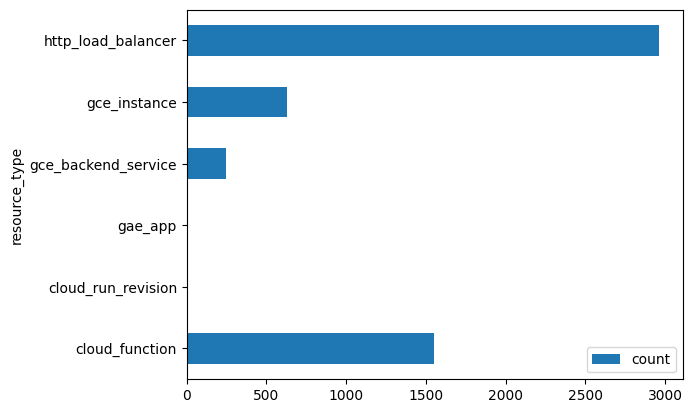

In [48]:
count_by_resource_type.plot(kind='barh')
plt.show()
